In [2]:
import game

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

import agent

In [3]:
def visualize(stateHistory, actionHistory, rewardHistory, N):
    inventory = stateHistory[:, 0, :]
    orders = actionHistory[:, 1, :]
    serviceTimes = actionHistory[:, 0, :]
    reorderPoints = stateHistory[:, 1, :]
    
    print("Time Series")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        
        alpha = 1 if i == 2 else 0.3
#         plt.step(range(N+1), inventory[:, i] * np.roll(np.sign(orders[:, i]), -1), label="inventory")        
        plt.plot(range(N+1), inventory[:, i], label="inventory", alpha=alpha, c='b', linestyle='--', drawstyle='steps')
        plt.step(range(N+1), orders[:, i], label="order quantity", c='orange')
        if i == 2:
            plt.step(range(N+1), reorderPoints[:, i], label="reorder point", c='green')
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Service Time")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), serviceTimes[:, i], label="service time")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    
    print("Inventory")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), inventory[:, i] * np.sign(orders[:, i]), label="inventory")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Rewards")
    plt.figure(figsize=(20, 4))
    plt.step(range(N+1), rewardHistory)
    plt.show()

In [4]:
learningParams = {
    "gamma": 0.2,
    "alpha": 1,
    "epsilon": 0.5
}

envParams = {
    "inventoryCost": [1000, 5, 1000], #[5, 1000, 1000], # 
    "muDemand": 2,
    "stdDemand": 0.1,
    "retailerOrder": 10,
    "stockoutCost": 10000, #50000,
    "N": 1000
}

In [5]:
plannerAgent = agent.PlannerWithPolicyGradient(learningParams, envParams["retailerOrder"])
plannerAgent.policy_estimator.stdVal = 10

1/1 [==============================] - 0s 35ms/step
Time Series


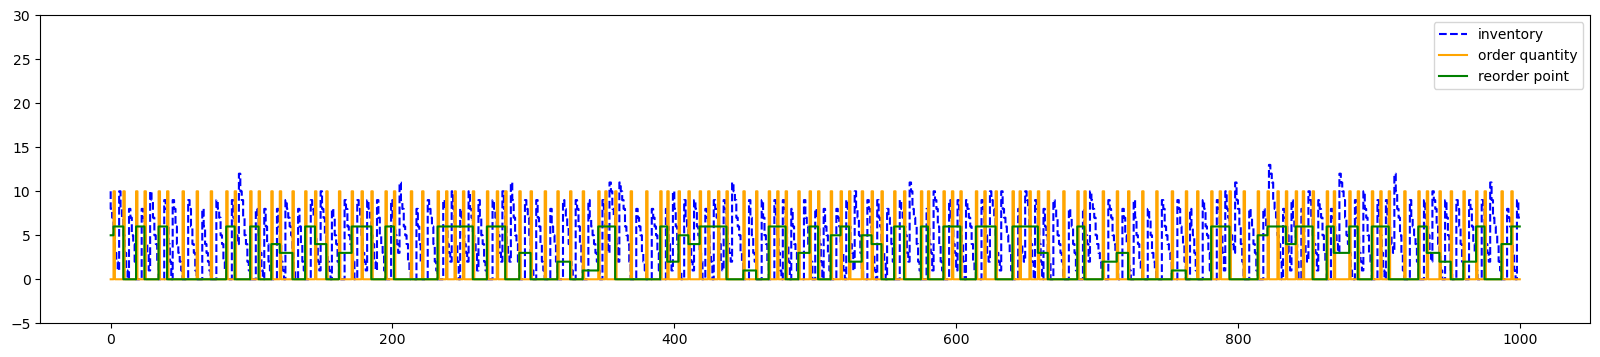

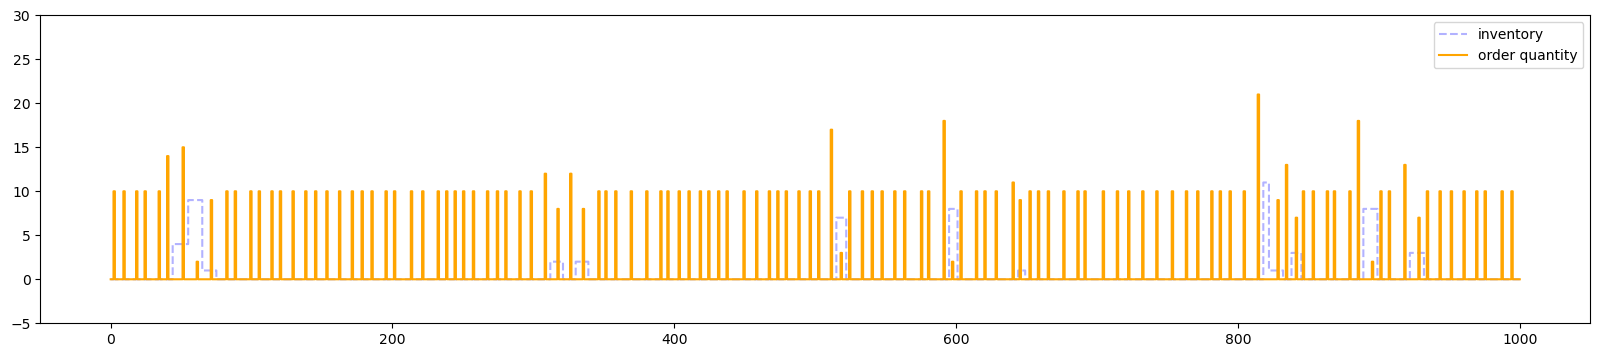

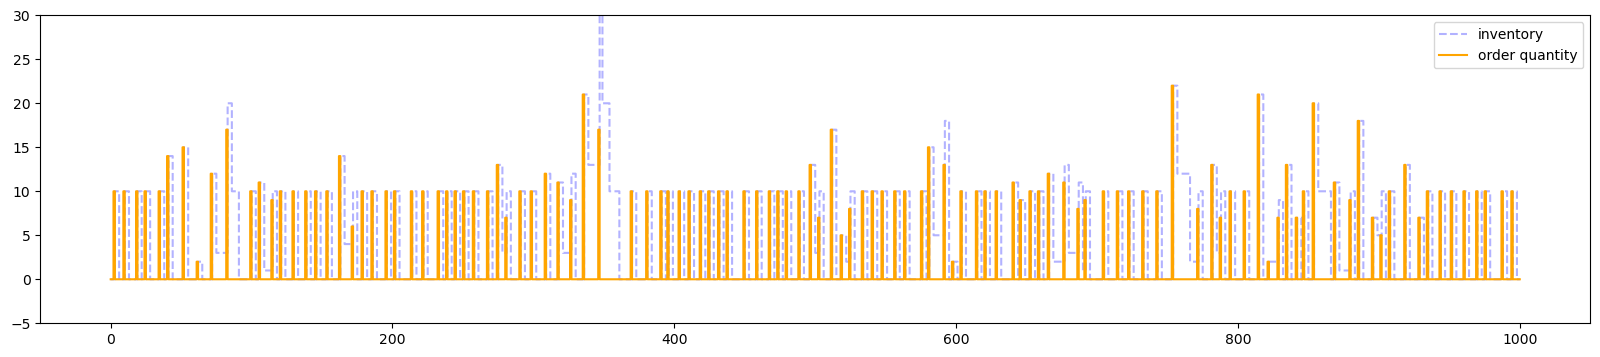

Service Time


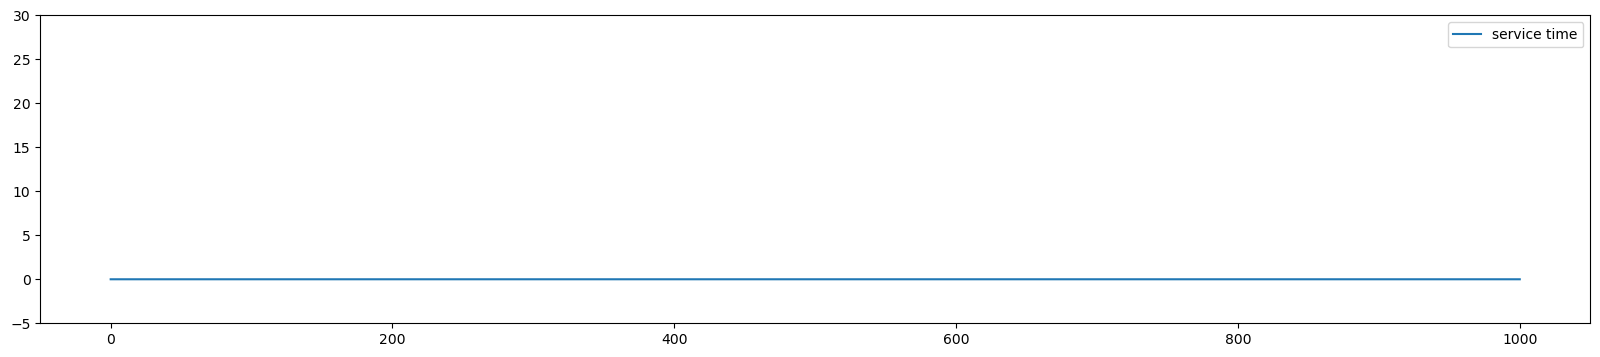

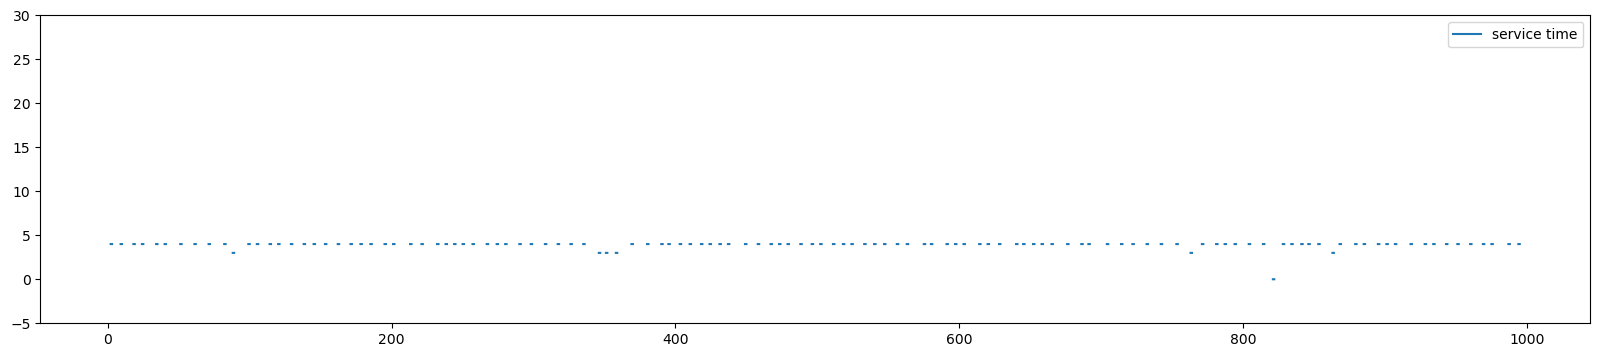

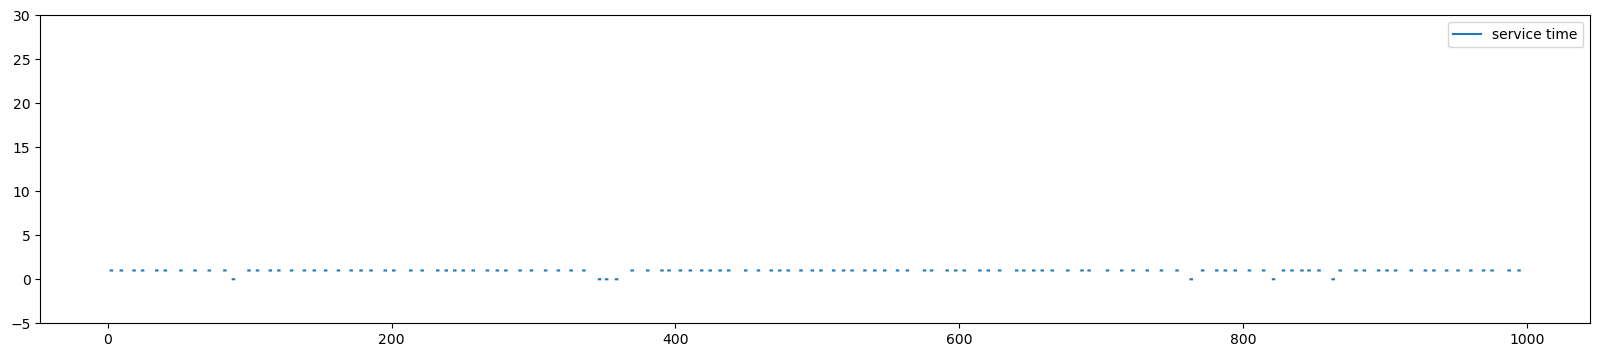

Inventory


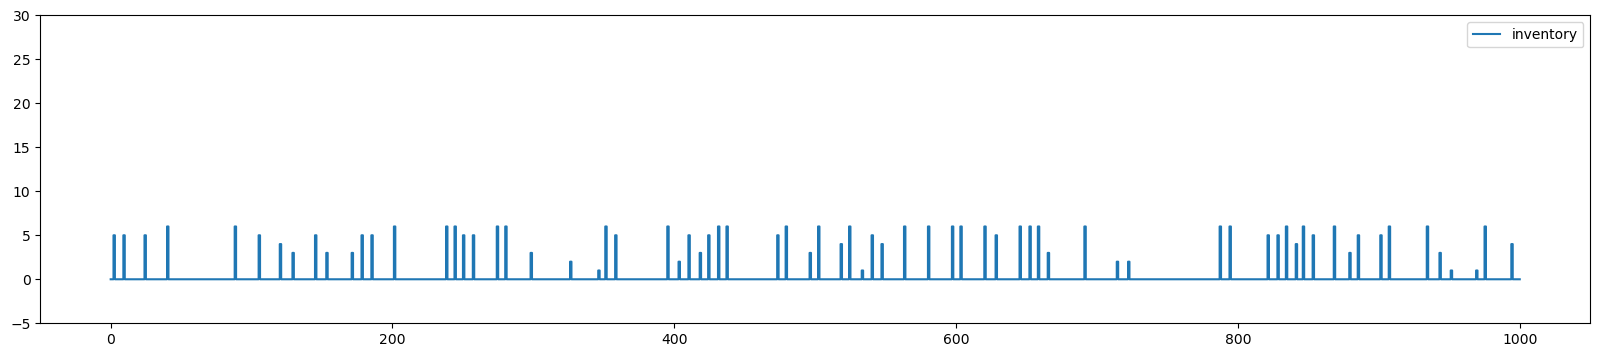

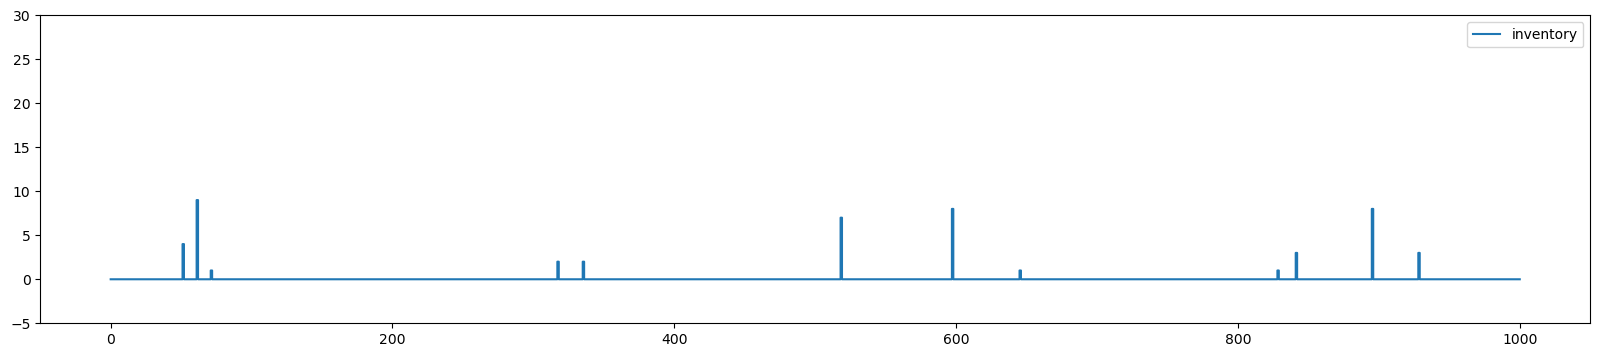

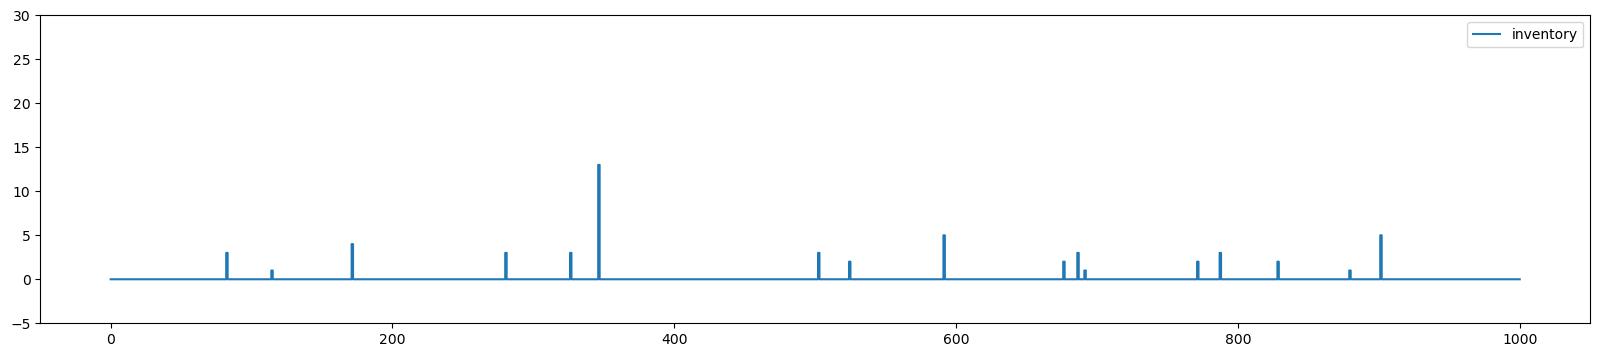

Rewards


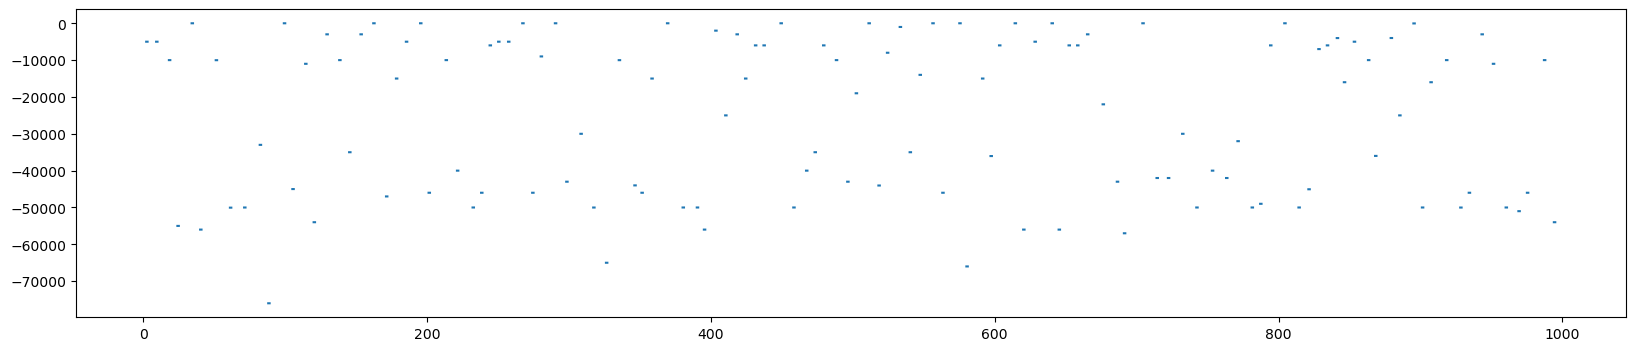

In [6]:
stateHistory, actionHistory, rewardHistory, experiences = game.runEpisode(envParams, plannerAgent, train=False)

visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])

In [7]:
rewardsAll = []
experienceAll = []
N = 200
for i in tqdm_notebook(range(N)):
    # play the game while trainings
    plannerAgent.policy_estimator.stdVal = 10
    _, _, rewards, experiences = game.runEpisode(envParams, plannerAgent, train=True)
    experienceAll.extend(experiences)
    
    # test
    plannerAgent.policy_estimator.stdVal = 0
    _, _, rewardHistory, _ = game.runEpisode(envParams, plannerAgent, train=False)
    averageRewards = np.nansum(rewardHistory)/np.count_nonzero(~np.isnan(rewardHistory))
    rewardsAll.append(averageRewards)
    
    if (i % 3 == 0): # & (i > 0):
        print(plannerAgent.value_estimator.predict(np.array([0, 0, 0])))
        print(plannerAgent.policy_estimator.predict(np.array([0, 0, 0]), capacity=[30, 30, 30], retailerOrderQty=10))
        plt.figure(figsize=(10, 5))
        plt.plot(rewardsAll)
        plt.show()
        

C:\Users\root\AppData\Local\Temp\ipykernel_3980\2774231855.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


KeyboardInterrupt: 

In [ ]:
plt.hist(plannerAgent.policy_estimator.targetRecorder)
plt.show()

y = [10 * np.exp((x-1000) / 1000) for x in plannerAgent.policy_estimator.targetRecorder]
# y = [10 * np.exp(x / 2000) for x in plannerAgent.policy_estimator.targetRecorder]
plt.scatter(plannerAgent.policy_estimator.targetRecorder, y, alpha=0.2)
plt.ylim((0, 10))
plt.xlim((-10000, 0))
plt.show()

plt.hist(y, range=(0, 100))
plt.xlim((0, 100))
plt.show()

In [ ]:
plannerAgent.policy_estimator.stdVal = 0
envParams["N"] = 1000

print(envParams["inventoryCost"])
# play the game while training
stateHistory, actionHistory, rewardHistory, experiences = game.runEpisode(envParams, plannerAgent, train=False)

visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])

In [ ]:
# note reorder point
reorderPoints = stateHistory[:, 1, 2]
meanReorderPoint = reorderPoints.mean()

orders = actionHistory[:, 1, :]

# note inventories 0
node0Inventories = stateHistory[:, 0, 0] 
filterInv = np.roll(np.sign(orders[:, 0]), -1)
node0Inventories = node0Inventories[np.where(filterInv == 1)]
node0InventoryMean = node0Inventories.mean() if (len(node0Inventories) > 0) else 0

# note inventories 1
node1Inventories = stateHistory[:, 0, 1] 
filterInv = np.roll(np.sign(orders[:, 1]), -1)
node1Inventories = node1Inventories[np.where(filterInv == 1)]
node1InventoryMean = node1Inventories.mean() if (len(node1Inventories) > 0) else 0

print(envParams)
print(node0InventoryMean, node1InventoryMean, meanReorderPoint)